---
title: "Data Cleaning"
format:
    html: 
        code-fold: false
---

The data cleaning phase is a crucial and often time-consuming part of any machine learning project. The dataset I am working with contains over 600 columns, which need to be narrowed down to the most relevant ones for analysis. Preparing the data carefully is essential for successful exploratory data analysis (EDA) and modeling. During the process, new issues often arise, particularly when working with large datasets where it's impossible to anticipate every challenge upfront. This is why data cleaning is considered an iterative process that evolves as the project progresses.

To ensure the data is cleaned accurately, I relied on the NYC Public Schools' School Quality Reports Educator Guide: High Schools 2022–23 [@NYCPublicSchoolsInfoHub_2024] as a data dictionary. This guide helped me understand the meaning behind many of the columns, allowing me to clean and organize the data effectively for future analysis.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sodapy import Socrata
from scipy.stats import skew
import warnings
warnings.filterwarnings('ignore')
pd.set_option('future.no_silent_downcasting', True)

Read in data

In [54]:
quality_tabs = pd.read_excel('../../data/raw-data/202223-hs-sqr-results.xlsx', skiprows=3, nrows=506, sheet_name=None)
ACS_df = pd.read_csv('../../data/raw-data/ACS_data.csv')
dropout_df = pd.read_csv('../../data/raw-data/dropout_data.csv', index_col=None)
mapping_df = pd.read_csv('../../data/mapping/2021_DOE_High_School_Directory.csv', index_col=None)

Concat 4 dicts of quality sheets, remove first row, drop duplicated columns

In [55]:
df_quality = pd.concat(quality_tabs.values(), axis=1)

df_quality = df_quality.iloc[1: , :]

df_quality = df_quality.loc[:, ~df_quality.T.duplicated(keep='first')]

Get columns we want from mapping, add zip code to df

In [56]:
#get columns 
df_mapping = mapping_df[['dbn','postcode']]
df_mapping.rename(columns={"dbn": "DBN", "postcode": "zip code"}, inplace=True)
#add zip code to df
df = df_quality.merge(df_mapping, on='DBN', how='left')

Find missing zip codes and export as csv

In [57]:
missing_school_zips = df.loc[df['zip code'].isna()]
missing_school_zips[['DBN', 'School Name']].drop_duplicates().to_csv('../../data/mapping/missing_list.csv', index=False)

Manually impute zip codes and read back in filled df

In [58]:
map2 = pd.read_csv('../../data/mapping/missing_list_labeled.csv')

Merge again and fill in missing zip codes

In [59]:
df = df.merge(map2, on='DBN', how='left')
df['zip code'] = df['zip code'].fillna(df['zipcode1'])
df.drop(columns=['school_name1', 'zipcode1'],inplace=True)

Add in ACS data

In [60]:
ACS_df['zip code tabulation area'] = pd.to_numeric(ACS_df['zip code tabulation area'])
ACS_df.rename(columns={"zip code tabulation area": "zip code"}, inplace=True)
df = df.merge(ACS_df, on='zip code', how='left')

Clean get columns we want from dropout df, filter for 2018 cohort year - which will match up with 2022-23 data, filter school and student type 

In [61]:
dropout_df = dropout_df.loc[dropout_df['cohort_year']==2018]
dropout_df = dropout_df.loc[dropout_df['report_category'].str.contains('School')]
dropout_df = dropout_df.loc[dropout_df['category']=='All Students']

dropout_df = dropout_df[['geographic_subdivision','category','school_name','dropout_1']]


Calculate mean dropout rate per school

In [62]:
dropout_df['dropout_1'] = pd.to_numeric(dropout_df['dropout_1'], errors='coerce')
transformed_df = dropout_df.groupby(['geographic_subdivision','category','school_name']).transform('mean')
dropout_df = pd.concat([dropout_df[['geographic_subdivision', 'category', 'school_name']], transformed_df], axis=1)
dropout_df = dropout_df.drop_duplicates()
dropout_df.rename(columns={"dropout_1": "dropout_rate", "school_name":"School Name"}, inplace=True)
dropout_df = dropout_df[['School Name','dropout_rate']]

Merge to final df

In [63]:
dropout_df['School Name'] = dropout_df['School Name'].str.lower()
df['School Name'] = df['School Name'].str.lower()
df = df.merge(dropout_df, on='School Name', how='left')

Pre cleaning df.head check

In [64]:
df.head()

,Unnamed: 0_x,DBN,School Name,School Type,Enrollment,Rigorous Instruction Rating,Collaborative Teachers Rating,Supportive Environment Rating,Effective School Leadership Rating,Strong Family-Community Ties Rating,...,Unnamed: 0_y,Percent No High School (25+),Percent Bachelor's Degree or Higher (25+),Percent Language Other Than English at Home,Percent Population with Disabilities,Percent Foreign-Born Population,Percent Households with Broadband Internet,Median Household Income,Percent Households on SNAP/Food Stamps,dropout_rate
0,NaN,01M292,orchard collegiate academy,High School,269.0,Meeting Target,Exceeding Target,Meeting Target,Meeting Target,Approaching Target,...,2578.0,16.2,38.1,53.0,13.0,38.1,76.1,43362.0,34.0,3.3
1,NaN,01M448,university neighborhood high school,High School,485.0,Exceeding Target,Exceeding Target,Exceeding Target,Exceeding Target,Meeting Target,...,2578.0,16.2,38.1,53.0,13.0,38.1,76.1,43362.0,34.0,2.9
2,NaN,01M450,east side community school,High School,389.0,Exceeding Target,Exceeding Target,Exceeding Target,Exceeding Target,Exceeding Target,...,2584.0,7.0,62.3,34.6,14.0,24.3,85.3,83344.0,18.0,0.0
3,NaN,01M539,"new explorations into science, technology and ...",High School,620.0,Meeting Target,Meeting Target,Exceeding Target,Exceeding Target,Exceeding Target,...,2578.0,16.2,38.1,53.0,13.0,38.1,76.1,43362.0,34.0,0.7
4,NaN,01M696,bard high school early college,High School,565.0,Exceeding Target,Approaching Target,Meeting Target,Meeting Target,Meeting Target,...,2578.0,16.2,38.1,53.0,13.0,38.1,76.1,43362.0,34.0,0.0


Pre Cleaning data types


In [65]:
df.dtypes.value_counts()

object     280
float64    275
Name: count, dtype: int64

According to the Educator Guide, "metrics with fewer than the minimum number of students are not reported and do not contribute to the school’s ratings because of confidentiality considerations and the unreliability of measurements based on small numbers" [@NYCPublicSchoolsInfoHub_2024]. These are shown in the data as values of 'N<15' and 'N<5'. We cannot impute 0 for these values since that would fasely discredit the school. Instead, I changed these values to NA and did not include them when processing. Similarly, we will make values that are '<95%' as their max 95%.

In [66]:
df = df.replace('N<15', np.nan).infer_objects(copy=False)
df = df.replace('N<5', np.nan).infer_objects(copy=False)

df = df.replace('> 95%', int(0.95)).infer_objects(copy=False)

Pre cleaning missingness

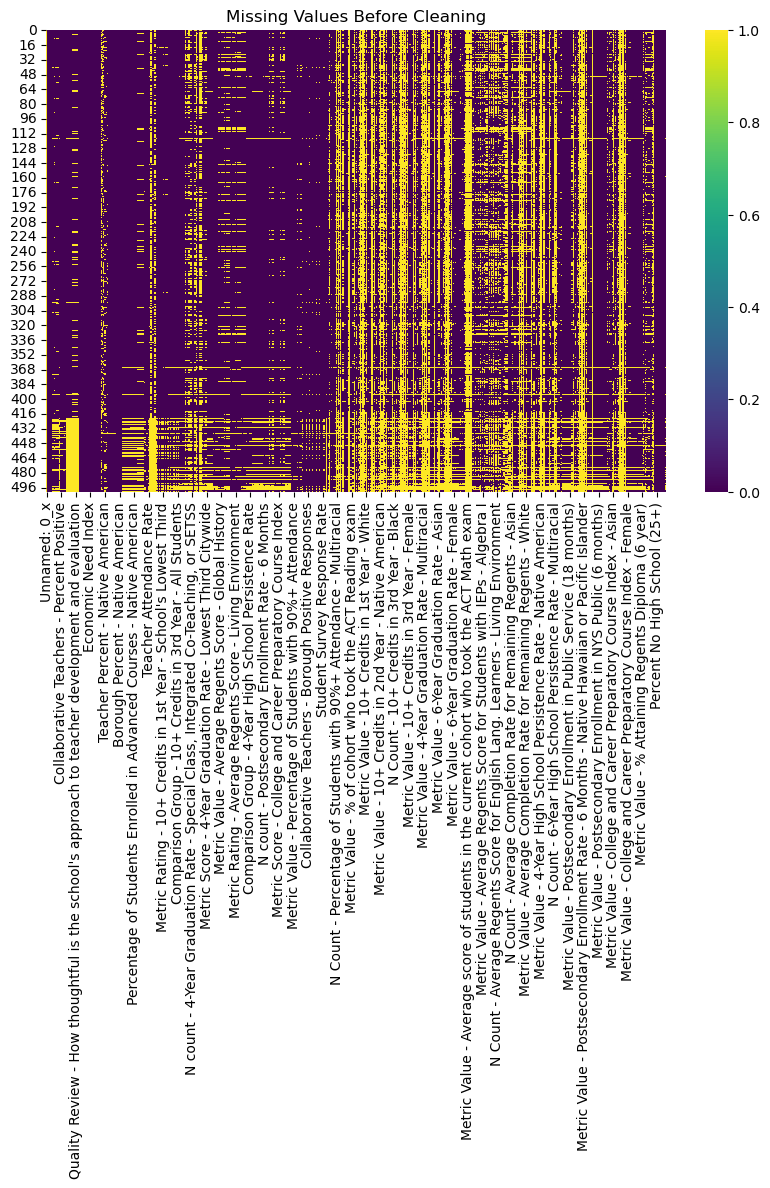

In [67]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=True, cmap="viridis")
plt.title("Missing Values Before Cleaning")
plt.show()

Remove columns by string:

Unnamed: remove NA columns

N count / metric rating / metric score / comparison group: we just need metric value % columns, these give the same info

positive responses / percent positive: remove borough and city positive response columns - we just need element score for these metrics

quality review: these metrics are included in the Element score metrics

Remove granular columns: scores by specific courses, demographics

In [68]:
string_check = "Unnamed|N count|metric rating|metric score|comparison group|positive responses|percent positive|Quality Review"

#specific courses
specific_courses = "Chemistry|Earth Science|Algebra|US History|Geometry|Global History|Living Environment|Credits"

#demographics
demographics = 'Asian|White|Native|Black|Hispanic|Male|Female|English Lang|ELL|IEPs|NYSAA'

df = df.loc[:, ~df.columns.str.contains(string_check, regex=True, case=False)]
df = df.loc[:, ~df.columns.str.contains(specific_courses, regex=True, case=False)]

df= df.loc[:, ~(df.columns.str.contains(demographics, regex=True, case=False) & ~(df.columns.str.contains('percent ', regex=True, case=False)))]

Drop School Type (they are all High Schools) and columns with survey response questions, we have score columns for this

In [69]:
df = df.drop(columns=['School Type','Rigorous Instruction Rating','Collaborative Teachers Rating','Supportive Environment Rating','Effective School Leadership Rating','Strong Family-Community Ties Rating','Trust Rating','Student Achievement Rating'], axis=1)


### Feature Engineering

Average rates that are 4 and 6 years then drop

In [70]:
df['Graduation Rate'] = df[['Metric Value - 6-Year Graduation Rate - All Students', 'Metric Value - 4-Year Graduation Rate - All Students']].mean(axis=1)
df['% Attaining Regents Diploma'] = df[['Metric Value - % Attaining Regents Diploma (4 year)', 'Metric Value - % Attaining Regents Diploma (6 year)']].mean(axis=1)
df['High School Persistence Rate'] = df[['Metric Value - 6-Year High School Persistence Rate', 'Metric Value - 4-Year High School Persistence Rate']].mean(axis=1)
df = df.drop(columns=['Metric Value - 6-Year Graduation Rate - All Students',
                    'Metric Value - 4-Year Graduation Rate - All Students',
                    'Metric Value - % Attaining Regents Diploma (4 year)',
                    'Metric Value - % Attaining Regents Diploma (6 year)',
                    'Metric Value - 4-Year High School Persistence Rate',
                    'Metric Value - 6-Year High School Persistence Rate'])

Combine student demographic percentages - group black and hispanic since its the majority. Combine teacher demographic percentages - 2 groups: Teacher White and Teacher Other. Remove nearby student percentages. Remove Borough Percentages.

In [71]:
#student demographic 
df['Student Percent - Black and Hispanic'] = (df['Student Percent - Black'] + df['Student Percent - Hispanic'])
df['Student Percent - Other'] = df['Student Percent - Native American'] + df['Student Percent - Native Hawaiian or Pacific Islander'] + df['Student Percent - Asian'] + df['Student Percent - White']
df = df.drop(['Student Percent - White','Student Percent - Native American', 'Student Percent - Native Hawaiian or Pacific Islander','Student Percent - Asian', 'Student Percent - Black', 'Student Percent - Hispanic'], axis=1)

#teacher demographic 
df['Teacher - Other'] = df['Teacher Percent - Native American'] + df['Teacher Percent - Native Hawaiian or Pacific Islander'] + df['Teacher Percent - Asian'] + df['Teacher Percent - Hispanic'] + df['Teacher Percent - Black']
df = df.drop(['Teacher Percent - Native American', 'Teacher Percent - Native Hawaiian or Pacific Islander','Teacher Percent - Asian', 'Teacher Percent - Black', 'Teacher Percent - Hispanic'], axis=1)

#nearby student percentages
df = df.drop(['Nearby Student Percent - White','Nearby Student Percent - Native American', 'Nearby Student Percent - Native Hawaiian or Pacific Islander','Nearby Student Percent - Asian', 'Nearby Student Percent - Black', 'Nearby Student Percent - Hispanic'], axis=1)

#Borough Percentages
df = df.drop(['Borough Percent - White','Borough Percent - Native American', 'Borough Percent - Native Hawaiian or Pacific Islander','Borough Percent - Asian', 'Borough Percent - Black', 'Borough Percent - Hispanic'], axis=1)

Only keep general postsecondary enrollment and graduation columns

In [72]:
df = df.loc[:, ~((df.columns.str.contains("postsecondary enrollment", case=False)) & ~(df.columns == "Metric Value - Postsecondary Enrollment Rate"))]
df= df.loc[:, ~(df.columns.str.contains('graduated|graduation', regex=True, case=False) & ~(df.columns == "Graduation Rate"))]

Extract District and Borough from DBN column and map borough name to value

DBN: (##(District)X(Borough)###(School ID))

In [73]:
df = df.copy()
df['District'] = df['DBN'].str[0:2]
df['Borough'] = df['DBN'].str[2:3]

borough_map = {'M': 'Manhattan', 'K': 'Brooklyn', 'X': 'Bronx', 'Q':'Queens', 'R':'Staten Island'}
df['Borough'] = df['Borough'].map(borough_map) 

Combine ACT metrics and SAT metrics, drop repetitive regents metrics

In [74]:
#ACT 
df['Percent who took ACT'] = df[['Metric Value - % of cohort who took the ACT English exam','Metric Value - % of cohort who took the ACT Reading exam']].mean(axis=1)
df['Percent with 20+ ACT'] = df[['Metric Value - % of students in the current cohort who took the ACT English exam who scored 20+','Metric Value - % of students in the current cohort who took the ACT Math exam who scored 21+']].mean(axis=1)
df = df.drop(['Metric Value - % of cohort who took the ACT English exam','Metric Value - % of cohort who took the ACT Reading exam','Metric Value - % of students in the current cohort who took the ACT English exam who scored 20+','Metric Value - % of students in the current cohort who took the ACT Math exam who scored 21+'], axis=1)

#SAT 
df['Percent College Ready based on SAT Math'] = df['Metric Value - % of students in the current cohort who took the SAT Math exam who passed the college ready threshold']
df.drop(['Metric Value - % of students in the current cohort who took the SAT Math exam who passed the college ready threshold','Metric Value - % of students in the current cohort who took the SAT Reading and Writing exam and scored 480+'], axis=1, inplace=True )

#Regents
df = df.drop(columns=['Metric Value - % of students who took the English Regents exam and are college ready (scored 70+)','Metric Value - % of students who took the English Regents exam in the current year who scored 65+'])

Combine 8th grade proficiency metrics and drop lowest third citywide metrics since it is based on average grade 8 proficiency  

In [75]:
df['Average Grade 8 Proficiency'] = df[['Average Grade 8 English Proficiency', 'Average Grade 8 Math Proficiency']].mean(axis=1)
df.drop(columns =['Average Grade 8 English Proficiency','Average Grade 8 Math Proficiency'],inplace=True)

df = df.loc[:, ~(df.columns.str.contains('Lowest Third'))]

Drop students recommended for Individualized Education Programs (IEPs)

In [76]:
df.drop(['Percentage of students recommended for general ed settings with Special Ed Teacher Support Services (SETSS)','Percentage of students recommended for Integrated Co-Teaching (ICT) services','Percentage of students recommended for Special Class (SC) services'], axis=1, inplace=True)

Drop columns that give same info as targets: graduation rate and chronic absenteeism

In [77]:
df.drop(columns=['High School Persistence Rate','% Attaining Regents Diploma','Metric Value - Percentage of Students with 90%+ Attendance','Average Student Attendance'], inplace=True)

Drop columns that are captured in the College and Career Preparatory Course Index (CCPCI) [@NYCPublicSchoolsInfoHub_2024].

In [78]:
df = df.drop(columns=['Metric Value - % Scoring 3+ on any AP Exam',
       'Metric Value - % Passing a NYCPS-certified CPCC Course',
       'Metric Value - % Passing an Industry-Recognized Technical Assessment',
       'Metric Value - % Scoring 4+ on any IB Exam',
       "Metric Value - % Earning a Grade of 'C' or Higher for College Credit",
       'Metric Value - % Scoring 65+ on Alg2, Chem, or Phys Regents Exam',
       'Metric Value - % Earning a Diploma with an Arts Endorsement',
       'Metric Value - % Earning a Diploma with a CTE Endorsement'], axis=1)

Make course columns with low occurence into binary rather than percentages - more interperable. Drop the originals

In [79]:
df['CLEP_enrolled'] = (df['Percentage of Students Enrolled in a College Level Examination Program (CLEP)'] > 0).astype(float)
df['IB_enrolled'] = (df['Percentage of Students Enrolled in an IB Course'] > 0).astype(float)
df['NYCPS_college_prep_enrolled'] = (df['Percentage of Students Enrolled in an NYCPS-certified College Preparatory Course'] > 0).astype(float)
df['Took_ACT'] = (df['Percent who took ACT'] > 0).astype(float)


df = df.drop(columns=['Percentage of Students Enrolled in a College Level Examination Program (CLEP)',
                    'Percentage of Students Enrolled in an IB Course',
                    'Percentage of Students Enrolled in an NYCPS-certified College Preparatory Course',
                    'Percent who took ACT', 'Percent with 20+ ACT'], axis=1)

**Handle Data Types**: Converting all columns to numeric is essential for EDA to create plots and for modeling as regression will only take numeric values.

In [80]:
#convert rate % to float
df['Student Survey Response Rate'] = pd.to_numeric(df['Student Survey Response Rate'].str[:-1])
df['Teacher Survey Response Rate'] = pd.to_numeric(df['Teacher Survey Response Rate'].str[:-1])
df['Parent Survey Response Rate'] = pd.to_numeric(df['Parent Survey Response Rate'].str[:-1])

#convert all metric value columns to numeric
df.loc[:, df.columns.str.contains('Metric Value')] = df.loc[:, df.columns.str.contains('Metric Value')].apply(pd.to_numeric, errors='coerce')

**Handle Missingness:** To address the large amounts of missing data, I first removed columns where more than 50% of the data was missing. This step significantly reduced the size of the dataframe by eliminating over 100 columns that wouldn't have contributed meaningfully to the analysis due to the high volume of missing values. Next, I focused on imputing data for columns with less than 10% missing values. For imputation, I used the skew of the distribution to determine the best method. If the skew was greater than an absolute value of 0.5, I imputed using the median, as this is more robust to outliers. If the distribution appeared to be approximately normal, I used the mean for imputation. Finally, I removed the remaining three columns with missing data that did not meet the threshold, ensuring a complete and clean dataset for analysis.

In [81]:
len(df.columns)

71

In [82]:
def handle_missingness(df, threshold=0.1):
    """Function for imputing data using skew when missingness < 10% and removing columns with missingness > 50% """
    for col in df.columns:
        missingness = df[col].isna().sum() / len(df)
        if missingness < 0.1:
            if df[col].dtype == 'float64':
                col_skew = skew(df[col].dropna()) 
                if abs(col_skew) > 0.5:
                    df[col] = df[col].fillna(df[col].median())
                else: 
                    df[col] = df[col].fillna(df[col].mean())
            elif df[col].dtype == 'object':
                df[col] = df[col].fillna(df[col].mode()[0]) 
        elif missingness > 0.5:
            df.drop([col], axis=1, inplace=True)
    return df

In [83]:
df = handle_missingness(df)

Check null count of each column

In [84]:
df.isnull().sum().sort_values(ascending=False).head(20)

Metric Value - Average score of students in the current cohort who took the SAT Reading and Writing exam    76
Metric Value - Average score of students in the current cohort who took the SAT Math exam                   76
Student Achievement - Section Score                                                                         72
Metric Value - Average Completion Rate for Remaining Regents                                                52
Percent Male                                                                                                 0
Percent Female                                                                                               0
Percent English Language Learners                                                                            0
Percent Students with IEPs                                                                                   0
Economic Need Index                                                                                          0
P

Drop remaining columns with missingness

In [85]:
df = df.drop(columns=['Metric Value - Average score of students in the current cohort who took the SAT Reading and Writing exam','Metric Value - Average score of students in the current cohort who took the SAT Math exam','Student Achievement - Section Score','Metric Value - Average Completion Rate for Remaining Regents'], axis=1)


Post cleaning data check

In [86]:
df.dtypes.value_counts()

float64    51
object      4
Name: count, dtype: int64

The remaining object columns are 'DBN', 'School Name', 'District', and 'Borough'. We will keep these for EDA purposes. 

In [87]:
df.select_dtypes(include=['object']).columns

Index(['DBN', 'School Name', 'District', 'Borough'], dtype='object')

Save processed df to csv

In [88]:
df.to_csv('../../data/processed-data/processed_df.csv', index=None)

Post cleaning df.head check

In [89]:
df.head()

,DBN,School Name,Enrollment,Percent Female,Percent Male,Percent Neither Female nor Male,Percent English Language Learners,Percent Students with IEPs,Economic Need Index,Percent Overage / Undercredited,...,Student Percent - Black and Hispanic,Student Percent - Other,District,Borough,Percent College Ready based on SAT Math,Average Grade 8 Proficiency,CLEP_enrolled,IB_enrolled,NYCPS_college_prep_enrolled,Took_ACT
0,01M292,orchard collegiate academy,269.0,0.468,0.532,0.0,0.063,0.253,0.866,0.041,...,0.766,0.227,01,Manhattan,0.136,2.715,0.0,0.0,0.0,0.0
1,01M448,university neighborhood high school,485.0,0.487,0.513,0.0,0.118,0.210,0.814,0.029,...,0.625,0.371,01,Manhattan,0.225,3.050,0.0,0.0,0.0,0.0
2,01M450,east side community school,389.0,0.458,0.542,0.0,0.013,0.290,0.638,0.003,...,0.684,0.283,01,Manhattan,0.370,3.010,0.0,0.0,1.0,1.0
3,01M539,"new explorations into science, technology and ...",620.0,0.508,0.492,0.0,0.005,0.185,0.429,0.005,...,0.249,0.705,01,Manhattan,0.834,3.755,0.0,0.0,0.0,1.0
4,01M696,bard high school early college,565.0,0.577,0.423,0.0,0.005,0.147,0.482,0.004,...,0.391,0.570,01,Manhattan,0.762,3.840,0.0,0.0,0.0,1.0


Post cleaning missingness check

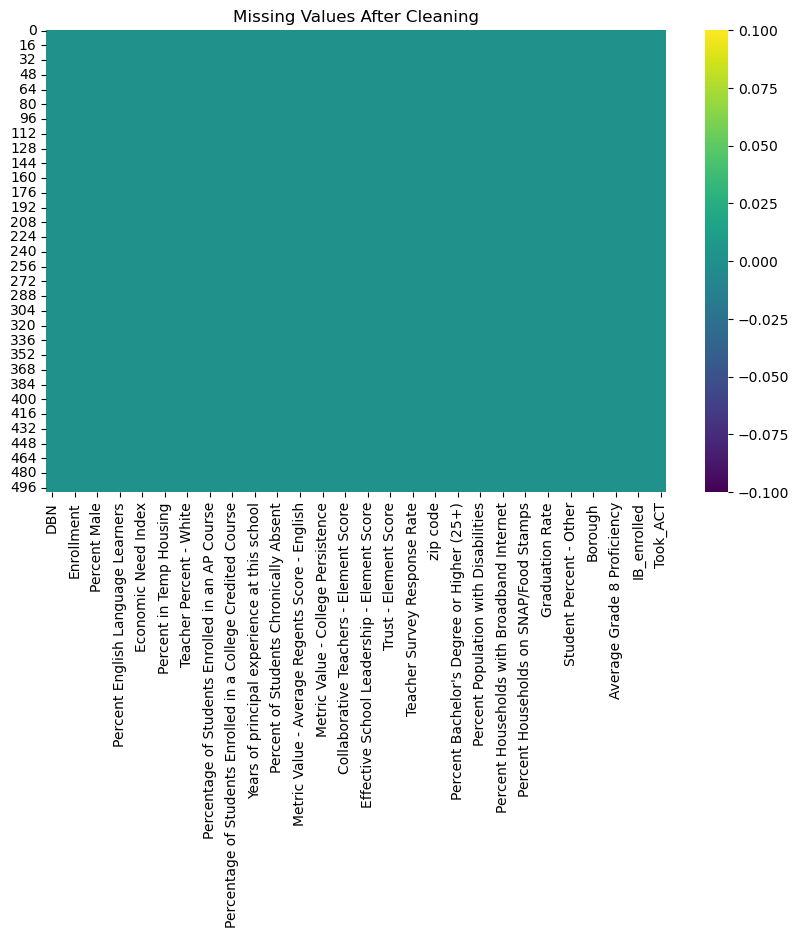

In [90]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=True, cmap="viridis")
plt.title("Missing Values After Cleaning")
plt.show()

### Conclusion
I chose to work with this specific subset of the data because it retains the key columns I am most interested in exploring. I decided to drop columns that were too granular, such as specific course types and certain demographic data, which were not directly relevant to my analysis. Additionally, some metric columns contained redundant information already captured by the 'Metric Value' columns I kept. As a result, I removed the N count, metric rating, metric score, comparison group, and positive response columns. After this filtering process, the dataset is now streamlined, containing 55 columns and 501 rows, ensuring a more focused and manageable analysis.